In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import scipy as sp
from scipy.misc import derivative
from scipy.interpolate import CubicSpline

In [24]:
N = 1000
NUMERO_DE_PONTOS = 1000
A = 16e-4

pos = np.arange(0, 0.030, 0.030/NUMERO_DE_PONTOS)
lc = 0.70 - pos
f = -102.04e-5/(pos + 2e-3)**2
g0 = 2e-3
u0 = 4e-7*np.pi
CORRENTE_BOBINA = [1, 5, 15]


In [25]:

#pontos fornecidos
H = np.array([0,
              68,
              135,
              203,
              271,
              338,
              406,
              474,
              542,
              609,
              1100,
              1500,
              2500,
              4000,
              5000,
              9000,
              12000,
              20000,
              25000])

B = np.array([0,
              0.733,
              1.205,
              1.424,
              1.517,
              1.560,
              1.588,
              1.617,
              1.631,
              1.646,
              1.689,
              1.703,
              1.724,
              1.731,
              1.738,
              1.761,
              1.770,
              1.80,
              1.816])

H_linear = np.array([0, 68])
B_linear = np.array([0, 0.733])

#interpolação
func = CubicSpline(B, H, bc_type='natural')
func_linear = CubicSpline(B_linear, H_linear, bc_type='natural')

B_pnts = np.arange(0, 1.82, 1.82/NUMERO_DE_PONTOS)

H_it = func(B_pnts)
H_linear = func_linear(B_pnts)


In [26]:
#obtenção dos pontos no intervalo de variação
dB = (B_pnts/NUMERO_DE_PONTOS)*np.arange(B_pnts.shape[0])
pos_new = np.repeat(pos, dB.shape[0], axis=0).reshape((dB.shape[0], pos.shape[0]))


In [27]:
# fluxo concatenado
lambda_f = N*dB*A 

# correntes
i_real = 1/N * (func(dB)*(0.7-pos_new) + dB*pos_new/u0 + dB*g0/u0) 
i_linear = 1/N * (func_linear(dB)*(0.7-pos_new) + dB*pos_new/u0 + dB*g0/u0) 
i_ideal = 1/N * (dB*pos_new/u0 + dB*g0/u0) 

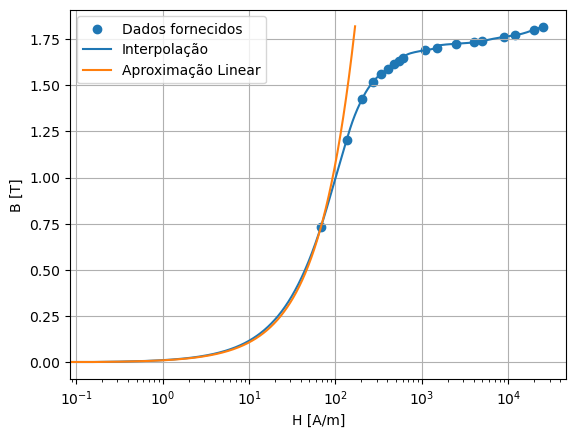

In [77]:
#plot do gráfico de BxH

plt.ylabel('B [T]')
plt.xlabel('H [A/m]')
plt.xscale('log')
plt.scatter(H, B, label='Dados fornecidos')
plt.plot(H_it, B_pnts, label='Interpolação')
plt.plot(H_linear, B_pnts, label='Aproximação Linear')
plt.grid()
plt.legend()
plt.show()

In [56]:
#Funcao para calculo da força magnetica

def forca_magnetica(corrente_bobina):
    #intervalo de corrente
    I_interval = np.arange(0, corrente_bobina, corrente_bobina/NUMERO_DE_PONTOS)

    #vetor para armazenar a energia
    wc_real = np.zeros(shape=NUMERO_DE_PONTOS)
    wc_ideal = np.zeros(shape=NUMERO_DE_PONTOS)
    wc_linear = np.zeros(shape=NUMERO_DE_PONTOS)

    #iteração nos pontos para obtenção das curvas de fluxo e posteriormente a coeenergia
    for idx in range(NUMERO_DE_PONTOS):
        flu_corrente_real = interp1d(i_real[idx], lambda_f, fill_value='extrapolate')
        flu_corrente_ideal = interp1d(i_ideal[idx], lambda_f, fill_value='extrapolate')
        flu_corrente_linear = interp1d(i_linear[idx], lambda_f, fill_value='extrapolate')

        lambda_real = flu_corrente_real(I_interval)
        lambda_ideal = flu_corrente_ideal(I_interval)
        lambda_linear = flu_corrente_linear(I_interval)

        wc_real[idx] = sp.integrate.trapezoid(lambda_real, I_interval)            
        wc_ideal[idx] = sp.integrate.trapezoid(lambda_ideal, I_interval)
        wc_linear[idx] = sp.integrate.trapezoid(lambda_linear, I_interval)  

    #obtenção da força atraves da derivada da coenergia em função da posição
    forca_real = derivative(interp1d(pos, wc_real, fill_value='extrapolate'), pos, dx=(pos/NUMERO_DE_PONTOS))
    forca_linear = derivative(interp1d(pos, wc_linear, fill_value='extrapolate'), pos, dx=(pos/NUMERO_DE_PONTOS))
    forca_ideal = derivative(interp1d(pos, wc_ideal, fill_value='extrapolate'), pos, dx=(pos/NUMERO_DE_PONTOS))

    return forca_real, forca_linear, forca_ideal

In [78]:
#chamando a função da força para cada caso de corrente
forca_real_1, forca_linear_1, forca_ideal_1 = forca_magnetica(corrente_bobina=1)
forca_real_5, forca_linear_5, forca_ideal_5 = forca_magnetica(corrente_bobina=5)
forca_real_15, forca_linear_15, forca_ideal_15 = forca_magnetica(corrente_bobina=15)

C:\Users\Danil\AppData\Local\Temp\ipykernel_620\1182746249.py:20: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  forca_real = derivative(interp1d(pos, wc_real, fill_value='extrapolate'), pos, dx=(pos/NUMERO_DE_PONTOS))
c:\Users\Danil\anaconda3\Lib\site-packages\scipy\_lib\_finite_differences.py:145: RuntimeWarning: invalid value encountered in divide
  return val / prod((dx,) * n, axis=0)
C:\Users\Danil\AppData\Local\Temp\ipykernel_620\1182746249.py:21: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  forca_linear = derivative(interp1d(pos, wc_linear, fill_value='extrapolate'), pos, dx=(pos/NUMERO

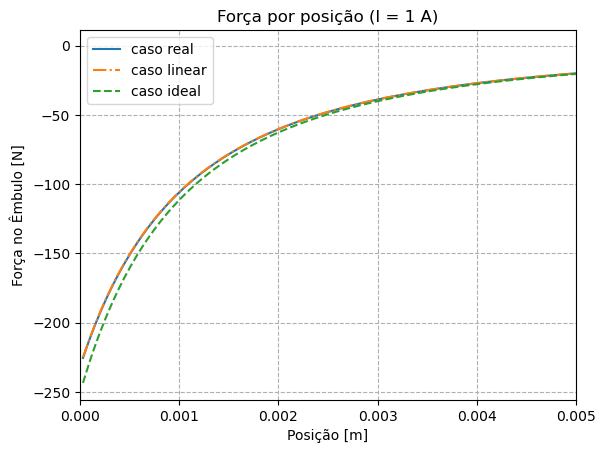

In [62]:
plt.ylabel('Força no Êmbulo [N]')
plt.xlabel('Posição [m]')
plt.xlim([0, 0.005])
plt.title('Força por posição (I = 1 A)')

plt.plot(pos, forca_real_1, label='caso real', linestyle='-')
plt.plot(pos, forca_linear_1, label='caso linear', linestyle='-.')
plt.plot(pos, forca_ideal_1, label='caso ideal', linestyle='--')

plt.grid(linestyle='--')
plt.legend()
plt.show()

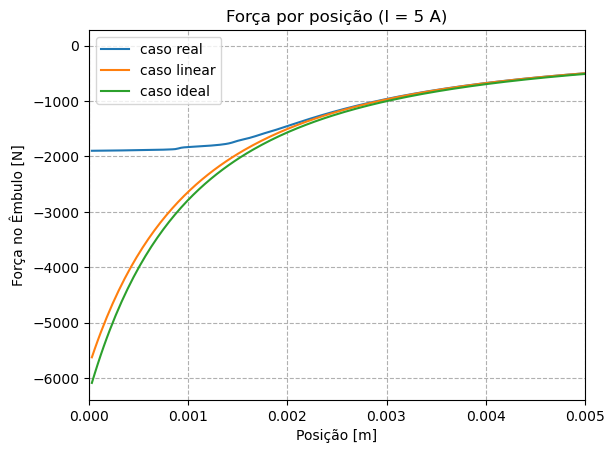

In [66]:
plt.ylabel('Força no Êmbulo [N]')
plt.xlabel('Posição [m]')
plt.title('Força por posição (I = 5 A)')

plt.xlim([0, 0.005])

plt.plot(pos, forca_real_5, label='caso real', linestyle='-')
plt.plot(pos, forca_linear_5, label='caso linear', linestyle='-')
plt.plot(pos, forca_ideal_5, label='caso ideal')

plt.grid(linestyle='--')
plt.legend()
plt.show()

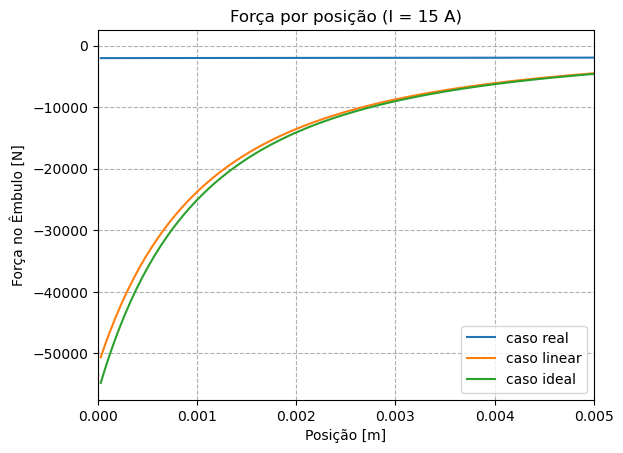

In [68]:
plt.ylabel('Força no Êmbulo [N]')
plt.xlabel('Posição [m]')
plt.title('Força por posição (I = 15 A)')

plt.xlim([0, 0.005])

plt.plot(pos, forca_real_15, label='caso real')
plt.plot(pos, forca_linear_15, label='caso linear')
plt.plot(pos, forca_ideal_15, label='caso ideal')

plt.grid(linestyle='--')
plt.legend()
plt.show()

In [69]:
ponto_5_mm = np.where(pos == pos[pos>=0.005][0])
ponto_20_mm = np.where(pos == pos[pos>=0.020][0])

vetor_correntes = np.arange(0.1, 28, 0.1)
vetor_aceleracoes = np.zeros(shape=(3,vetor_correntes.shape[0],pos.shape[0]))

m = 0.050 # massa --> 50g


In [79]:
for i in range(vetor_correntes.shape[0]):
    f_real, f_linear, f_ideal = forca_magnetica(corrente_bobina=vetor_correntes[i])
    vetor_aceleracoes[0][i] = f_real/m
    vetor_aceleracoes[1][i] = f_linear/m
    vetor_aceleracoes[2][i] = f_ideal/m

C:\Users\Danil\AppData\Local\Temp\ipykernel_620\1182746249.py:20: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  forca_real = derivative(interp1d(pos, wc_real, fill_value='extrapolate'), pos, dx=(pos/NUMERO_DE_PONTOS))
C:\Users\Danil\AppData\Local\Temp\ipykernel_620\1182746249.py:21: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  forca_linear = derivative(interp1d(pos, wc_linear, fill_value='extrapolate'), pos, dx=(pos/NUMERO_DE_PONTOS))
C:\Users\Danil\AppData\Local\Temp\ipykernel_620\1182746249.py:22: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be complete

In [73]:
#cáclulo da corrente máxima
i_maximo = 1/N * (H[-1]*(0.7-0.005) + B[-1]*0.005/u0 + B[-1]*g0/u0)     
print("Corrente máxima:", i_maximo, "A")

Corrente máxima: 27.49088818292087 A


In [38]:
posicao_final = 0.020
posicao_inicial = 0.005
intervalo_posicao = np.arange(posicao_inicial, posicao_final, (posicao_final-posicao_inicial)/NUMERO_DE_PONTOS)

vetor_tempos = np.zeros(shape=(3, vetor_correntes.shape[0]))
v_func = np.zeros(shape=(3, intervalo_posicao.shape[0]))

In [39]:
for i in range(vetor_correntes.shape[0]):
    for j in range(len(intervalo_posicao)):
        v_func[0][j] = np.sqrt(2*sp.integrate.trapezoid(abs(vetor_aceleracoes[0][i][1:j+1]), intervalo_posicao[1:j+1]))
        v_func[1][j] = np.sqrt(2*sp.integrate.trapezoid(abs(vetor_aceleracoes[1][i][1:j+1]), intervalo_posicao[1:j+1]))
        v_func[2][j] = np.sqrt(2*sp.integrate.trapezoid(abs(vetor_aceleracoes[2][i][1:j+1]), intervalo_posicao[1:j+1]))

    vetor_tempos[0][i] = sp.integrate.trapezoid(1/v_func[0][2:], intervalo_posicao[2:])
    vetor_tempos[1][i] = sp.integrate.trapezoid(1/v_func[1][2:], intervalo_posicao[2:])
    vetor_tempos[2][i] = sp.integrate.trapezoid(1/v_func[2][2:], intervalo_posicao[2:])

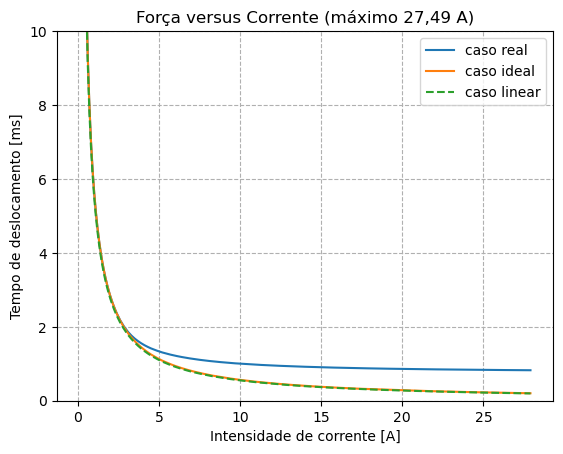

In [76]:
plt.ylabel('Tempo de deslocamento [ms]')
plt.xlabel('Intensidade de corrente [A]')

plt.ylim([0,10])
plt.title('Força versus Corrente (máximo 27,49 A)')
plt.plot(vetor_correntes, vetor_tempos[0]*1000, label='caso real')
plt.plot(vetor_correntes, vetor_tempos[2]*1000, label='caso ideal')
plt.plot(vetor_correntes, vetor_tempos[1]*1000, label='caso linear', linestyle='--')

plt.grid(linestyle='--')
plt.legend()
plt.show()